In [1]:
import numpy as num
import scipy as sci
import pandas as pan
import pylab as lab
from itertools import product
import pandas as pan
%matplotlib inline
#from mpi4py import MPI
#comm=MPI.COMM_WORLD
#rank=comm.Get_rank()


In [2]:
def FCC(a,b,c,T):
    T=num.array(T)
    first=num.array([0,0,0])
    second=num.array([a/2.,b/2.,0])
    third=num.array([0,b/2.,c/2.])
    fourth=num.array([a/2.,0,c/2.])
    coordinates=num.array([first+a*T,second+a*T,third+a*T,fourth+a*T])
    return(coordinates)
    
    
    
    
#------------------------------------------------------------------------------------------------------------------------



def Lattice(a,b,c,dim):
    LatticeCoordinates=[]
    size=range(-dim,dim+1)
    transVectors=list(product(size,size,size))
    for var in transVectors:
        LatticeCoordinates.append(FCC(a,b,c,var))
        
    LatticeCoordinates=num.array(LatticeCoordinates)
    shape=LatticeCoordinates.shape
    
    return LatticeCoordinates.reshape(shape[0]*shape[1],shape[2])
 
    
#-------------------------------------------------------------------------------------------------------------------------  
 

In [4]:
   
    
def EmbeddedEnergy(EmbeddedFunc,fEle,lattice,n,frame):
    hostDensity=[]
    for base in lattice:
        rep=lattice.shape[0]
        baseArray=num.repeat([base],rep,axis=0)
        diff=lattice-baseArray
        dist=num.sqrt(num.sum(num.multiply(diff,diff),axis=1))
        individualDensity=fEle(dist,n,frame)
        totalHost=num.sum(individualDensity)-fEle(0,n,frame)
        hostDensity.append(totalHost)
    EmbeddedEnergyIndivisual=EmbeddedFunc(num.array(hostDensity),n,frame)
    TotalEmbeddedEnergy=num.sum(EmbeddedEnergyIndivisual)
    return TotalEmbeddedEnergy



#---------------------------------------------------------------------------------------------------------------------------



def PairPotential(Pot,lattice,n,frame):
    potential=0
    dim=lattice.shape[0]
    AtomPairs=list(product(range(dim),range(dim)))
    for pair in AtomPairs:
        diff=lattice[pair[0]]-lattice[pair[1]]
        dist=num.sqrt(num.sum(num.multiply(diff,diff)))
        if dist!=0:
            potential=potential+Pot(dist,n,frame)
    return potential/2
    
 
    
#---------------------------------------------------------------------------------------------------------------------------
def EmbeddedEnergyDaw(EmbeddedFunc,fEle,lattice):
    hostDensity=[]
    for base in lattice:
        rep=lattice.shape[0]
        baseArray=num.repeat([base],rep,axis=0)
        diff=lattice-baseArray
        dist=num.sqrt(num.sum(num.multiply(diff,diff),axis=1))
        individualDensity=fEle(dist[dist<5])
        totalHost=num.sum(individualDensity)-fEle(0)
        if (totalHost<.25):
            hostDensity.append(totalHost)
    EmbeddedEnergyIndivisual=EmbeddedFunc(num.array(hostDensity))
    TotalEmbeddedEnergy=num.sum(EmbeddedEnergyIndivisual)
    return TotalEmbeddedEnergy

#----------------------------------------------------------------------------------------------------------------------

def PairPotentialDaw(Z,lattice):
    potential=0
    dim=lattice.shape[0]
    AtomPairs=list(product(range(dim),range(dim)))
    for pair in AtomPairs:
        diff=lattice[pair[0]]-lattice[pair[1]]
        dist=num.sqrt(num.sum(num.multiply(diff,diff)))
        if dist!=0 and dist<5:
            potential=potential+Z(dist)**2/float(dist)
    return potential/2

In [5]:
from scipy.interpolate import interp1d
Z=pan.read_csv("Pt.VC.Z.dat",sep="\t",names=["r","Z"])
ZFrame=pan.DataFrame(Z)
ZFunc = interp1d(ZFrame.r, ZFrame.Z, kind='cubic')

F=pan.read_csv("Pt.VC.F.dat",sep="\t",names=["rho","F"])
FFrame=pan.DataFrame(F)
FFunc=interp1d(FFrame.rho,FFrame.F)

rho=pan.read_csv("Pt.VC.rho.dat",sep="\t",names=["r","rho"])
RhoF=pan.DataFrame(rho)
RFunc=interp1d(RhoF.r,RhoF.rho)

OSError: File b'Pt.VC.Z.dat' does not exist

In [5]:
def fEle(r,n,frame):
    data=list(frame.iloc[n])
    atom,name,lat,re,fe,rhoe,alpha,beta,A,B,kappa,lam,Fn0,Fn1,Fn2,Fn3,F0,F1,F2,F3,eta,Fe=data
    
    return fe*num.exp(-beta*(r/re-1))/(1+(r/re-lam)**20)

def phiN_(r,n,frame):
    data=list(frame.iloc[n])
    atom,name,lat,re,fe,rhoe,alpha,beta,A,B,kappa,lam,Fn0,Fn1,Fn2,Fn3,F0,F1,F2,F3,eta,Fe=data
    return A*num.exp(-alpha*(r/re-1))/(1+(r/re-kappa)**20)
#def phiE(r,q):
#    return (1-q/N)*B*num.exp(-beta*(r/re-1))/(1+(r/re-kappa)**20)

def phiE_(r,n,frame):
    data=list(frame.iloc[n])
    atom,name,lat,re,fe,rhoe,alpha,beta,A,B,kappa,lam,Fn0,Fn1,Fn2,Fn3,F0,F1,F2,F3,eta,Fe=data
    return B*num.exp(-beta*(r/re-1))/(1+(r/re-kappa)**20)

def phiT_(r,n,frame):
    return phiN_(r,n,frame)+phiE_(r,n,frame)



def F_(rho,n,frame):
    func=[]
    data=list(frame.iloc[n])
    atom,name,lat,re,fe,rhoe,alpha,beta,A,B,kappa,lam,Fn0,Fn1,Fn2,Fn3,F0,F1,F2,F3,eta,Fe=data
    rhon=0.85*rhoe
    rho0=1.15*rhoe
    for var in rho:
        if(var<rhon):
            func.append(Fn0*(var/rhon-1)**0+Fn1*(var/rhon-1)**1+Fn2*(var/rhon-1)**2+Fn3*(var/rhon-1)**3)
        elif (var>=rhon and var<rho0):
            func.append(F0*(var/rhoe-1)**0+F1*(var/rhoe-1)**1+F2*(var/rhoe-1)**2+F3*(var/rhoe-1)**3)
        else:
            func.append(Fe*(1-num.log((var/rhoe)**eta))*(var/rhoe)**eta)
    func=num.asarray(func)
    return func

In [7]:
Zhou=pan.read_csv("Zhou.info.dat",sep="\t",names=["atom","type","lat","re","fe","rhoe","alpha","beta","A","B"\
                                                     ,"kappa","lam","Fn0","Fn1","Fn2","Fn3","F0","F1","F2","F3","eta","Fe"])

In [8]:
Zhou

,atom,type,lat,re,fe,rhoe,alpha,beta,A,B,...,Fn0,Fn1,Fn2,Fn3,F0,F1,F2,F3,eta,Fe
0,Cu,Zhou,FCC,2.556162,1.554485,22.150141,7.669911,4.090619,0.327584,0.468735,...,-2.176490,-0.140035,0.285621,-1.750834,-2.19,0,0.702991,0.683705,0.921150,-2.191675
1,Ag,Zhou,FCC,2.891814,1.106232,15.539255,7.944536,4.237086,0.266074,0.386272,...,-1.729619,-0.221025,0.541558,-0.967036,-1.75,0,0.983967,0.520904,1.149461,-1.751274
2,Au,Zhou,FCC,2.885034,1.529021,21.319637,8.086176,4.312627,0.230728,0.336695,...,-2.930281,-0.554034,1.489437,-0.886809,-2.98,0,2.283863,0.494127,1.286960,-2.981365
3,Ni,Zhou,FCC,2.488746,2.007018,27.984706,8.029633,4.282471,0.439664,0.632771,...,-2.693996,-0.066073,0.170482,-2.457442,-2.70,0,0.282257,0.102879,0.509860,-2.700493
4,Pd,Zhou,FCC,2.750897,1.595417,22.770550,7.605017,4.056009,0.385412,0.545121,...,-2.320473,-0.421263,0.966525,-0.932685,-2.36,0,1.966273,1.396717,1.399758,-2.362609
5,Pt,Zhou,FCC,2.771916,2.336509,34.108882,7.079952,3.775974,0.449644,0.593713,...,-4.099542,-0.754764,1.766503,-1.578274,-4.17,0,3.474733,2.288323,1.393490,-4.174332
6,Al,Zhou,FCC,2.886166,1.392302,20.226537,6.942419,3.702623,0.251519,0.313394,...,-2.806783,-0.276173,0.893409,-1.637201,-2.83,0,0.929508,-0.682320,0.779208,-2.829437
7,Pb,Zhou,FCC,3.499723,0.647872,8.906840,8.468412,4.516486,0.134878,0.203093,...,-1.419644,-0.228622,0.630069,-0.560952,-1.44,0,0.921049,0.108847,1.172361,-1.440494
8,Fe,Zhou,BCC,2.481987,1.885957,20.041463,9.818270,5.236411,0.392811,0.646243,...,-2.534992,-0.059605,0.193065,-2.282322,-2.54,0,0.200269,-0.148770,0.391750,-2.539945
9,Mo,Zhou,BCC,2.728100,2.723710,29.354065,8.393531,4.476550,0.708787,1.120373,...,-3.692913,-0.178812,0.380450,-3.133650,-3.71,0,0.875874,0.776222,0.790879,-3.712093


In [9]:
def TotalEnergy(a,T,n,frame):
    energy=[]
    for latConst in a:
        lattice=Lattice(latConst,T)
        Embedd=EmbeddedEnergy(F_,fEle,lattice,n,frame)
        pairPotential=PairPotential(phiT_,lattice,n,frame)
        energy.append(Embedd+pairPotential)
    return num.array(energy)



def TotalEnergyDaw(a,T):
    energy=[]
    for latConst in a:
        lattice=Lattice(latConst,T)
        Embedd=EmbeddedEnergyDaw(FFunc,RFunc,lattice)
        pairPotential=PairPotentialDaw(ZFunc,lattice)
        energy.append(Embedd+pairPotential)
    return num.array(energy)

In [8]:
x=num.linspace(0,10,100)
ene=TotalEnergy(x,1,5,Zhou)

In [9]:
y=num.linspace(2,4,100)
eneDaw=TotalEnergyDaw(y,1)

In [ ]:
eneDaw

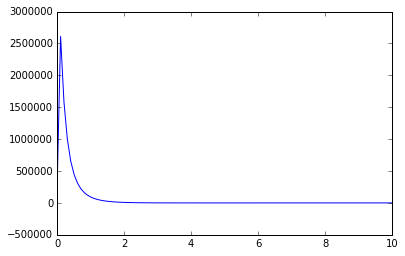

In [9]:
fig1=lab.figure()
lab.plot(x,ene,label="Zhou")
#lab.xlim([4.5,6])
#lab.ylim([-90,-60])

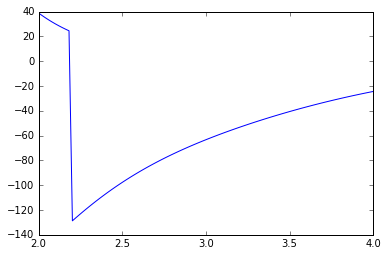

In [168]:
fig2=lab.figure()
lab.plot(y,eneDaw,label="Daw")
#lab.xlim([2.18,2.25])
#lab.ylim([-10000,10000])

In [95]:
base=[[1,2,3]]

In [96]:
num.repeat(base,10,axis=0)

array([[1, 2, 3],
       [1, 2, 3],
       [1, 2, 3],
       [1, 2, 3],
       [1, 2, 3],
       [1, 2, 3],
       [1, 2, 3],
       [1, 2, 3],
       [1, 2, 3],
       [1, 2, 3]])

In [18]:
lattice=Lattice(1,1)
lattice.shape



(108, 3)

In [152]:
count=0
for base in lattice:
        rep=lattice.shape[0]
        baseArray=num.repeat([base],rep,axis=0)
        diff=lattice-baseArray
        dist=num.sqrt(num.sum(num.multiply(diff,diff),axis=1))
        print dist
        print "==="
        

[ 0.          0.70710678  0.70710678  0.70710678]
===
[ 0.70710678  0.          0.70710678  0.70710678]
===
[ 0.70710678  0.70710678  0.          0.70710678]
===
[ 0.70710678  0.70710678  0.70710678  0.        ]
===


In [157]:
dim=lattice.shape[0]
AtomPairs=list(product(range(dim),range(dim)))
for pair in AtomPairs:
    diff=lattice[pair[0]]-lattice[pair[1]]
    dist=num.sqrt(num.sum(num.multiply(diff,diff)))
    print dist
    print "++++"
   

0.0
++++
0.707106781187
++++
0.707106781187
++++
0.707106781187
++++
0.707106781187
++++
0.0
++++
0.707106781187
++++
0.707106781187
++++
0.707106781187
++++
0.707106781187
++++
0.0
++++
0.707106781187
++++
0.707106781187
++++
0.707106781187
++++
0.707106781187
++++
0.0
++++


In [6]:
lat=Lattice(3.52,3)

TypeError: Lattice() missing 2 required positional arguments: 'c' and 'dim'

In [5]:
lines=[]
lines.append("""<OpenMD version=2>
  <MetaData>
    molecule{
      name = "Ni";
      atom[0]{
	      type = "Ni_FQ";
	      position(0.0, 0.0, 0.0);
      }
    }
	

 component{
      type = "Ni";
  nMol =        1372;
    }


minimizer {
  useMinimizer = False;
  method = CG;
  maxIterations = 5000;
}




  flucQ {
    propagator = "Langevin";
    targetTemp = 1;
    dragCoefficient = 1;
  }

forceFieldFileName = "metalsFQ.frc";
forceField="EAM";
//forceField = "FlucQ";
outputFluctuatingCharges = true;
outputElectricField = true;
ensemble = NVE;
dt = 0.1;
runTime = 0.1;
sampleTime = 100;
statusTime = 1;

uniformField=(0,0,0);

cutoffMethod = "shifted_force";
cutoffRadius = 13.5;
electrostaticScreeningMethod = "DAMPED";
statFileFormat = "TIME|TOTAL_ENERGY|POTENTIAL_ENERGY|KINETIC_ENERGY|TEMPERATURE|PRESSURE|VOLUME|CONSERVED_QUANTITY|SYSTEM_DIPOLE";
dampingAlpha = 0.14;

targetTemp = 100;
tauThermostat = 1000;
tauBarostat = 1e6;

tempSet = "false";
useInitialTime = "false";
useInitialExtendedSystemState = "false";

## Last run using OpenMD version: 2.4, revision: fd0f4c5f3cdcbc202c6bcfaa808dcc9f85e3c147
  </MetaData>
  <Snapshot>
    <FrameData>
        Time: 0
        Hmat: {{ 24.64, 0, 0 }, { 0, 24.64, -0 }, { 0, 0, 24.64}}
  Thermostat: 0 , 0
    Barostat: {{ 0, 0, 0 }, { 0, 0, 0 }, { 0, 0, 0 }}
    </FrameData>
    <StuntDoubles>
    """)
for item in range(lat.shape[0]):
    lines.append(str(item))
    lines.append("\t")
    lines.append("pv")
    lines.append("\t")
    lines.append(str(lat[item,0]))
    lines.append("\t")
    lines.append(str(lat[item,1]))
    lines.append("\t")
    lines.append(str(lat[item,2]))
    lines.append("\t")
    lines.append("0")
    lines.append("\t")
    lines.append("0")
    lines.append("\t")
    lines.append("0")
    lines.append("\n")
    
lines.append(""" </StuntDoubles>
  </Snapshot>
</OpenMD>""")    
fileOut=open("../VacancyFormation/SimulationFileNi.omd",'w')
fileOut.writelines(lines)
fileOut.close()

NameError: name 'lat' is not defined

In [18]:
latticeSpacing=3.52
print lat.shape
print lat.shape[0]/4
print num.ceil(num.power(lat.shape[0]/4,1/3.))
size=num.ceil(num.power(lat.shape[0]/4,1/3.))*latticeSpacing
print "Box size is: ", size
vol=pow(size,3)
print vol

(1372, 3)
343
7.0
Box size is:  24.64
14959.673344


In [107]:
3.92/

343

In [119]:
(20661.046784-pow(26.68783737,3))/20661.046784

0.08000000221783889

In [87]:
p=Lattice(1,1,1,0)
for var in p:
    print(var)

[ 0.  0.  0.]
[ 0.   0.5  0.5]
[ 0.5  0.5  0. ]
[ 0.5  0.   0.5]


In [7]:
def L12(lattice,dim,file1,file2,A,B):
    omd=open(file1,"w")
    xyz=open(file2,"w")
    a,b,c=lattice
    var=Lattice(a,b,c,dim)
    countA=var.shape[0]/4
    print("%s==%d"%(A,countA))
    countB=3*countA
    print("%s==%d"%(B,countB))
    
    
    count=0
    count2=countA
    xyz.write("%d\n\n"%(countA+countB))
    for j in range(int(countA)):
        apos=4*j
        omd.write("%d\tpv\t%f\t%f\t%f\t%f\t%f\t%f\n"%(count,var[apos][0],var[apos][1],var[apos][2],0,0,0))
        xyz.write("%s\t%f\t%f\t%f\n"%(B,var[apos][0],var[apos][1],var[apos][2]))
        count=count+1
        omd.write("%d\tpv\t%f\t%f\t%f\t%f\t%f\t%f\n"%(count ,var[apos+2][0],var[apos+2][1],var[apos+2][2],0,0,0))
        count=count+1
        xyz.write("%s\t%f\t%f\t%f\n"%(A,var[apos+2][0],var[apos+2][1],var[apos+2][2]))
        
    for j in range(int(countA)):
        apos=4*j
        omd.write("%d\tpv\t%f\t%f\t%f\t%f\t%f\t%f\n"%(count ,var[apos+1][0],var[apos+1][1],var[apos+1][2],0,0,0))
        count=count+1
        omd.write("%d\tpv\t%f\t%f\t%f\t%f\t%f\t%f\n"%(count ,var[apos+2][0],var[apos+2][1],var[apos+2][2],0,0,0))
        count=count+1
        omd.write("%d\tpv\t%f\t%f\t%f\t%f\t%f\t%f\n"%(count ,var[apos+3][0],var[apos+3][1],var[apos+3][2],0,0,0))
        count=count+1
        xyz.write("%s\t%f\t%f\t%f\n"%(A,var[apos+1][0],var[apos+1][1],var[apos+1][2]))
        xyz.write("%s\t%f\t%f\t%f\n"%(A,var[apos+2][0],var[apos+2][1],var[apos+2][2]))
        xyz.write("%s\t%f\t%f\t%f\n"%(A,var[apos+3][0],var[apos+3][1],var[apos+3][2]))
        
    print(count)   

    
def L10(lattice,dim,file1,file2,A,B):
    omd=open(file1,"w")
    xyz=open(file2,"w")
    a,b,c=lattice
    var=Lattice(a,b,c,dim)
    countA=var.shape[0]/4
    print("%s==%d"%(A,2*countA))
    countB=countA
    print("%s==%d"%(B,2*countB))
    
    
    count=0
    count2=countA
    xyz.write("%d\n\n"%(2*countA+2*countB))
    for j in range(int(countA)):
        apos=4*j
        
        omd.write("%d\tpv\t%f\t%f\t%f\t%f\t%f\t%f\n"%(count,var[apos][0],var[apos][1],var[apos][2],0,0,0))
        xyz.write("%s\t%f\t%f\t%f\n"%(B,var[apos][0],var[apos][1],var[apos][2]))
        count=count+1
        
        
        omd.write("%d\tpv\t%f\t%f\t%f\t%f\t%f\t%f\n"%(count ,var[apos+2][0],var[apos+2][1],var[apos+2][2],0,0,0))
        xyz.write("%s\t%f\t%f\t%f\n"%(B,var[apos+2][0],var[apos+2][1],var[apos+2][2]))
        count=count+1
        
    for j in range(int(countA)):
        apos=4*j
        omd.write("%d\tpv\t%f\t%f\t%f\t%f\t%f\t%f\n"%(count ,var[apos+1][0],var[apos+1][1],var[apos+1][2],0,0,0))
        count=count+1
        
        omd.write("%d\tpv\t%f\t%f\t%f\t%f\t%f\t%f\n"%(count ,var[apos+3][0],var[apos+3][1],var[apos+3][2],0,0,0))
        count=count+1
        xyz.write("%s\t%f\t%f\t%f\n"%(A,var[apos+1][0],var[apos+1][1],var[apos+1][2]))
        xyz.write("%s\t%f\t%f\t%f\n"%(A,var[apos+3][0],var[apos+3][1],var[apos+3][2]))
        
    print(count)   


In [19]:


L10((3.92,3.92,3.92),5,"../L10/PtFeL10/FePt5.omd","../L10/PtFeL10/FePt5.xyz","Pt","Fe")

Pt==2662
Fe==2662
5324


In [16]:
num.array([3.6149,4.0853,4.0782,3.524,2.856])/num.sqrt(2)

array([ 2.5561203 ,  2.88874333,  2.88372288,  2.4918443 ,  2.01949697])

In [3]:
V=28.5474**3

In [8]:
s=(408.53e-2/4.0782)**3

In [9]:
V*s

23386.540469553616

In [81]:
28.3465/7

4.0495

In [149]:
final=-98385.6*0.043364
majority=-2.83
minority=-3.90
formation =(final - 1029* majority - 343 * minority)/1372.0
print(formation)

-0.012116004664723007


In [10]:
cohesive={"Cu":-3.51 ,"Au":-3.90,"Ag":-2.83,"Ni":-4.41,"Pt":3.72}
ele=["Cu","Pt"]
A3B={}
comb=[[A,B] for A in ele for B in ele]
for v1 in ele:
    energy=[]
    for v2 in ele:
        try:
            fileStat=open("../L21/"+v1+v2+".optimized")
            eneKj=float(fileStat.readline())
            ene=eneKj*0.043364
            formation =(ene - 1029* cohesive[v1] - 343 * cohesive[v2])/1372.0
            print("E: %f Maj: %s and Min: %s --> Energy: %.3f"%(ene/1372,v1,v2,formation))
            energy.append(formation)
        except:
        
            energy.append(999)
    A3B[v1]=energy
                                                                 
                                                        

df=pan.DataFrame.from_dict(A3B)
df.index=ele
df

E: -4.354163 Maj: Cu and Min: Pt --> Energy: -2.652


,Cu,Pt
Cu,999.000000,999
Pt,-2.651663,999


In [8]:
-2.652*0.16

-0.42432000000000003

E: -3.730726 Maj: Cu and Min: Au --> Energy: -0.123
E: -3.306157 Maj: Cu and Min: Ag --> Energy: 0.034
E: -3.747573 Maj: Cu and Min: Ni --> Energy: -0.013
E: -3.927539 Maj: Au and Min: Cu --> Energy: -0.125
E: -3.663942 Maj: Au and Min: Ag --> Energy: -0.031
E: -4.076153 Maj: Au and Min: Ni --> Energy: -0.049
E: -2.993026 Maj: Ag and Min: Cu --> Energy: 0.007
E: -3.109616 Maj: Ag and Min: Au --> Energy: -0.012
E: -3.125081 Maj: Ag and Min: Ni --> Energy: 0.100
E: -4.202642 Maj: Ni and Min: Cu --> Energy: -0.018
E: -4.330521 Maj: Ni and Min: Au --> Energy: -0.048
E: -3.850957 Maj: Ni and Min: Ag --> Energy: 0.164

In [151]:
final=-94696.8
majority="Ag"
minority="Cu"


formation =(final*0.043364 - 1029* cohesive[majority] - 343 * cohesive[minority])/1372.0
print(formation)

0.006973735276967618


In [189]:
data = {'col_1': [3, 2, 1, 0], 'col_2': ['a', 'b', 'c', 'd']}
pan.DataFrame.from_dict(data,orient="index",columns=['a','b','c','d'])

TypeError: from_dict() got an unexpected keyword argument 'columns'

In [222]:
-94023.543/1372*0.043364

-2.9717470252565596

In [228]:
26.2513/7

3.7501857142857142

In [229]:
26.2322/7

3.747457142857143

In [48]:
for i in range(1):
    print(i)

0
